In [54]:
# 라이브러리 기본 참조
from hossam import load_data
from pandas import DataFrame, concat, pivot_table, get_dummies, read_excel
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sb
import numpy as np
from scipy.stats import t, ttest_ind, normaltest, bartlett, levene
from math import sqrt


# 선형회귀를 위한 참조
import statsmodels.api as sm
from statsmodels.formula.api import ols

# 결과 검정을 위한 참조
from statsmodels.stats.diagnostic import linear_reset
from scipy.stats import zscore, probplot, shapiro, anderson, pearsonr, spearmanr
from statsmodels.stats.api import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from pingouin import anova, welch_anova, pairwise_tukey, pairwise_gameshowell

# VIF값을 계산하기 위한 참조
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statannotations.Annotator import Annotator

# 파이썬 기본 패키지
from itertools import combinations

In [55]:
origin = read_excel("2사분위수_데이터.xlsx")
dfq2 = origin.drop("Unnamed: 0", axis=1)
dfq2.head()

,price,carat,cut,color,clarity,x,y,z,depth,table
0,949,0.35,Premium,J,VS1,5.67,5.64,3.53,62.4,58.0
1,949,0.40,Premium,E,VS2,4.79,4.68,2.90,61.2,60.0
2,949,0.30,Very Good,E,IF,4.29,4.32,2.62,60.9,59.0
3,949,0.41,Good,D,VVS2,4.71,4.73,2.99,63.3,59.0
4,949,0.30,Ideal,E,VVS2,4.35,4.37,2.65,60.8,56.0


In [56]:
def ols_report(tbl, data):
    """
    OLS summary(tbl)와 데이터프레임(data)을 받아 회귀계수 표(rdf),
    모델 적합도 요약(result_report), 모형 보고 문장(model_report),
    변수별 보고 리스트(variable_reports)를 반환한다.

    Parameters
    ----------
    tbl : statsmodels.iolib.summary.Summary
        sm.OLS(...).fit().summary() 결과로 생성된 summary 객체.
    data : pandas.DataFrame
        종속변수와 독립변수를 모두 포함한 데이터프레임.

    Returns
    -------
    tuple
        (회귀계수 DataFrame, 적합도 요약 문자열, 모형 보고 문자열, 변수별 보고 리스트)
    """

    # 독립변수 이름(상수항 제외)
    xnames = [n for n in fit.model.exog_names if n != "const"]

    # 독립변수 부분 데이터 (VIF 계산용)
    indi_df = data.filter(xnames)

    # 독립변수 결과를 누적
    variables = []

    for i, v in enumerate(tbl.tables[1].data):
        # 한 행의 변수명 추출 후 목록에 있는지 확인
        name = v[0].strip()
        if name not in xnames:
            continue

        # VIF 계산을 위해 열 인덱스 조회
        j = list(indi_df.columns).index(name)
        vif = variance_inflation_factor(indi_df, j)

        # 유의확률과 별표 표시 함수
        p = float(v[4].strip())

        def stars(p):
            return "***" if p < 0.001 else "**" if p < 0.01 else "*" if p < 0.05 else ""

        # 한 변수에 대한 보고 정보 추가
        variables.append(
            {
                "종속변수": yname,  # 종속변수 이름 (외부에서 정의)
                "독립변수": name,  # 독립변수 이름
                "B": v[1].strip(),  # 비표준화 회귀계수(B)
                "표준오차": v[2].strip(),  # 계수 표준오차
                "Beta": float(fit.params[name])
                * (
                    data[name].std(ddof=1) / data[yname].std(ddof=1)
                ),  # 표준화 회귀계수(β)
                "t": "%s%s" % (v[3].strip(), stars(p)),  # t-통계량(+별표)
                "p-value": p,  # 계수 유의확률
                "공차": 1 / vif,  # 공차(Tolerance = 1/VIF)
                "vif": vif,  # 분산팽창계수
            }
        )

    rdf = DataFrame(variables)

    # summary 표에서 적합도 정보를 key-value로 추출
    result_dict = {}
    for idx in [0, 2]:
        for item in tbl.tables[idx].data:
            n = len(item)
            for j in range(0, n, 2):
                key = item[j].strip()[:-1]
                value = item[j + 1].strip()
                if not key or not value:
                    continue
                result_dict[key] = value

    # 적합도 보고 문자열 구성
    result_report = (
        f"𝑅({result_dict['R-squared']}), "
        f"𝑅^2({result_dict['Adj. R-squared']}), "
        f"𝐹({result_dict['F-statistic']}), "
        f"유의확률({result_dict['Prob (F-statistic)']}), "
        f"Durbin-Watson({result_dict['Durbin-Watson']})"
    )

    # 모형 보고 문장 구성
    p_f = float(result_dict["Prob (F-statistic)"])
    sig_text = "유의하다" if p_f <= 0.05 else "유의하지 않다"
    p_sign = "≤" if p_f <= 0.05 else ">"

    tpl = (
        "%s에 대하여 %s로 예측하는 회귀분석을 실시한 결과, "
        "이 회귀모형은 통계적으로 %s(F(%s,%s) = %s, p %s 0.05)."
    )

    model_report = tpl % (
        rdf["종속변수"][0],
        ",".join(list(rdf["독립변수"])),
        sig_text,
        result_dict["Df Model"],
        result_dict["Df Residuals"],
        result_dict["F-statistic"],
        p_sign,
    )

    # 변수별 보고 문장 리스트 구성
    variable_reports = []
    s = "%s의 회귀계수는 %s(p %s 0.05)로, %s에 대하여 %s 예측변인인 것으로 나타났다."

    for i in rdf.index:
        row = rdf.iloc[i]
        p_val = float(row["p-value"])
        p_sign_var = "≤" if p_val < 0.05 else ">"
        sig_word = "유의미한" if p_val < 0.05 else "유의하지 않은"

        variable_reports.append(
            s
            % (
                row["독립변수"],
                row["B"],
                p_sign_var,
                row["종속변수"],
                sig_word,
            )
        )

    return rdf, result_report, model_report, variable_reports

In [57]:
dfq2.shape

(13462, 10)

In [58]:
dfq2["price"].agg(["count", "min", "median", "mean", "max"])

count     13462.000000
min         949.000000
median     1571.000000
mean       1561.147526
max        2400.000000
Name: price, dtype: float64

In [59]:
dfq2.describe().T

,count,mean,std,min,25%,50%,75%,max
price,13462.0,1561.147526,442.840338,949.00,1133.00,1571.00,1917.00,2400.00
carat,13462.0,0.526674,0.124832,0.24,0.42,0.52,0.58,1.21
x,13462.0,5.158122,0.400432,0.00,4.84,5.17,5.38,6.86
y,13462.0,5.160296,0.461780,0.00,4.83,5.18,5.39,31.80
z,13462.0,3.183147,0.357593,0.00,2.98,3.19,3.31,31.80
depth,13462.0,61.677202,1.426259,52.20,61.00,61.70,62.40,78.20
table,13462.0,57.228049,2.255112,51.00,56.00,57.00,58.00,79.00


“Q2 구간의 표본수는 n = 13,462이며, 가격은 최소 949달러 ~ 최대 2,400달러 범위에 분포한다.”

In [60]:
dfq2_1 = dfq2.filter(["price", "carat", "x", "y", "z", "depth", "table"]).copy()

##dfq2_1 = get_dummies(dfq2_1, columns=["cut", "color", "clarity"], dtype="int", drop_first=True)

yname = "price"

x = dfq2_1.drop(yname, axis=1)
y = dfq2_1[yname]

x_input = sm.add_constant(x)
fit = sm.OLS(y, x_input).fit()
tbl1 = fit.summary()
print(tbl1)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.603
Model:                            OLS   Adj. R-squared:                  0.603
Method:                 Least Squares   F-statistic:                     3405.
Date:                Tue, 13 Jan 2026   Prob (F-statistic):               0.00
Time:                        17:47:00   Log-Likelihood:                -94912.
No. Observations:               13462   AIC:                         1.898e+05
Df Residuals:                   13455   BIC:                         1.899e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        885.0823    256.556      3.450      0.0

In [61]:
rdf, r, m, v = ols_report(tbl1, dfq2_1)
display(rdf)
print(m)

,종속변수,독립변수,B,표준오차,Beta,t,p-value,공차,vif
0,price,carat,1660.8497,105.129,0.468177,15.798***,0.00,0.005472,182.740338
1,price,x,308.2452,33.860,0.278726,9.104***,0.00,0.000476,2101.791328
2,price,y,41.0218,10.274,0.042776,3.993***,0.00,0.002052,487.414568
3,price,z,22.3424,9.606,0.018041,2.326*,0.02,0.006188,161.598852
4,price,depth,-18.1602,2.326,-0.058489,-7.808***,0.00,0.001582,632.133145
5,price,table,-16.6240,1.174,-0.084656,-14.157***,0.00,0.001797,556.517552


price에 대하여 carat,x,y,z,depth,table로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(6,13455) = 3405., p ≤ 0.05).


In [62]:
dfq2_2 = dfq2_1.drop("x", axis=1)
yname = "price"
x = dfq2_2.drop(yname, axis=1)
y = dfq2_2[yname]
x_input = sm.add_constant(x)
fit = sm.OLS(y, x_input).fit()
tbl1 = fit.summary()
rdf, r, m, v = ols_report(tbl1, dfq2_2)
display(rdf)
print(m)

,종속변수,독립변수,B,표준오차,Beta,t,p-value,공차,vif
0,price,carat,2545.1463,40.327,0.717451,63.113***,0.0,0.014940,66.932516
1,price,y,65.0126,9.960,0.067793,6.527***,0.0,0.002701,370.212426
2,price,z,35.0344,9.533,0.028290,3.675***,0.0,0.006244,160.154214
3,price,depth,-30.4748,1.898,-0.098150,-16.058***,0.0,0.002014,496.498912
4,price,table,-18.2845,1.164,-0.093111,-15.715***,0.0,0.002372,421.644660


price에 대하여 carat,y,z,depth,table로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(5,13456) = 4044., p ≤ 0.05).


In [63]:
dfq2_3 = dfq2_2.drop("depth", axis=1)
yname = "price"
x = dfq2_3.drop(yname, axis=1)
y = dfq2_3[yname]
x_input = sm.add_constant(x)
fit = sm.OLS(y, x_input).fit()
tbl1 = fit.summary()
rdf, r, m, v = ols_report(tbl1, dfq2_3)
display(rdf)
print(m)

,종속변수,독립변수,B,표준오차,Beta,t,p-value,공차,vif
0,price,carat,2395.4043,39.606,0.675241,60.480***,0.000,0.017105,58.463045
1,price,y,108.5127,9.676,0.113154,11.215***,0.000,0.002931,341.133603
2,price,z,10.7157,9.502,0.008653,1.128,0.259,0.007130,140.261033
3,price,table,-11.9359,1.105,-0.060782,-10.805***,0.000,0.005321,187.927362


price에 대하여 carat,y,z,table로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(4,13457) = 4898., p ≤ 0.05).


In [64]:
dfq2_4 = dfq2_3.drop("table", axis=1)
yname = "price"
x = dfq2_4.drop(yname, axis=1)
y = dfq2_4[yname]
x_input = sm.add_constant(x)
fit = sm.OLS(y, x_input).fit()
tbl1 = fit.summary()
rdf, r, m, v = ols_report(tbl1, dfq2_4)
display(rdf)
print(m)

,종속변수,독립변수,B,표준오차,Beta,t,p-value,공차,vif
0,price,carat,2331.6533,39.333,0.657270,59.280***,0.000,0.026345,37.957197
1,price,y,109.6208,9.717,0.114309,11.281***,0.000,0.007161,139.649365
2,price,z,21.4226,9.491,0.017299,2.257*,0.024,0.008016,124.747644


price에 대하여 carat,y,z로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(3,13458) = 6436., p ≤ 0.05).


In [65]:
dfq2_5 = dfq2_4.drop("y", axis=1)
yname = "price"
x = dfq2_5.drop(yname, axis=1)
y = dfq2_5[yname]
x_input = sm.add_constant(x)
fit = sm.OLS(y, x_input).fit()
tbl1 = fit.summary()
rdf, r, m, v = ols_report(tbl1, dfq2_5)
display(rdf)
print(m)

,종속변수,독립변수,B,표준오차,Beta,t,p-value,공차,vif
0,price,carat,2653.3451,27.218,0.747951,97.486***,0.000,0.030295,33.008819
1,price,z,30.3909,9.501,0.024541,3.199**,0.001,0.030295,33.008819


price에 대하여 carat,z로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(2,13459) = 9501., p ≤ 0.05).


In [69]:
df1q2 = dfq2.filter(["price", "carat", "cut", "color", "clarity"]).copy()

df1q2 = get_dummies(
    df1q2, columns=["cut", "color", "clarity"], dtype="int", drop_first=True
)

yname = "price"

x = df1q2.drop(yname, axis=1)
y = df1q2[yname]

x_input = sm.add_constant(x)
fit = sm.OLS(y, x_input).fit()
tbl1 = fit.summary()
print(tbl1)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                     4119.
Date:                Tue, 13 Jan 2026   Prob (F-statistic):               0.00
Time:                        17:53:26   Log-Likelihood:                -88513.
No. Observations:               13462   AIC:                         1.771e+05
Df Residuals:                   13443   BIC:                         1.772e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -2114.2517     20.261   -104.349

In [70]:
rdf, r, m, v = ols_report(tbl1, df1q2)
display(rdf)
print(m)

,종속변수,독립변수,B,표준오차,Beta,t,p-value,공차,vif
0,price,carat,4670.0579,17.987,1.316443,259.629***,0.0,0.048813,20.486181
1,price,cut_Good,88.6587,9.983,0.054409,8.881***,0.0,0.296714,3.370250
2,price,cut_Ideal,194.6242,8.968,0.219379,21.702***,0.0,0.065232,15.330015
3,price,cut_Premium,168.1241,9.150,0.159096,18.374***,0.0,0.129945,7.695561
4,price,cut_Very Good,141.6123,9.229,0.124855,15.344***,0.0,0.149941,6.669308
5,price,color_E,-86.2959,5.004,-0.080954,-17.244***,0.0,0.408915,2.445496
6,price,color_F,-141.5719,5.227,-0.126537,-27.085***,0.0,0.423114,2.363427
7,price,color_G,-202.7447,5.230,-0.189485,-38.766***,0.0,0.373382,2.678223
8,price,color_H,-315.3971,6.261,-0.220604,-50.372***,0.0,0.532017,1.879638
9,price,color_I,-473.9949,7.473,-0.265691,-63.428***,0.0,0.613925,1.628863


price에 대하여 carat,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,color_E,color_F,color_G,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(18,13443) = 4119., p ≤ 0.05).


In [71]:
reset_res = linear_reset(fit, power=2, use_f=True)
print(f"RESET F-statistic: {reset_res.fvalue:.4f}")
print(f"p-value: {reset_res.pvalue:.4f}")
if reset_res.pvalue < 0.05:
    print("선형성/기능형 위배 가능성이 있음 (5% 유의수준)")
else:
    print("선형성 가정 위배 근거 없음 (5% 유의수준)")

RESET F-statistic: 74.1768
p-value: 0.0000
선형성/기능형 위배 가능성이 있음 (5% 유의수준)


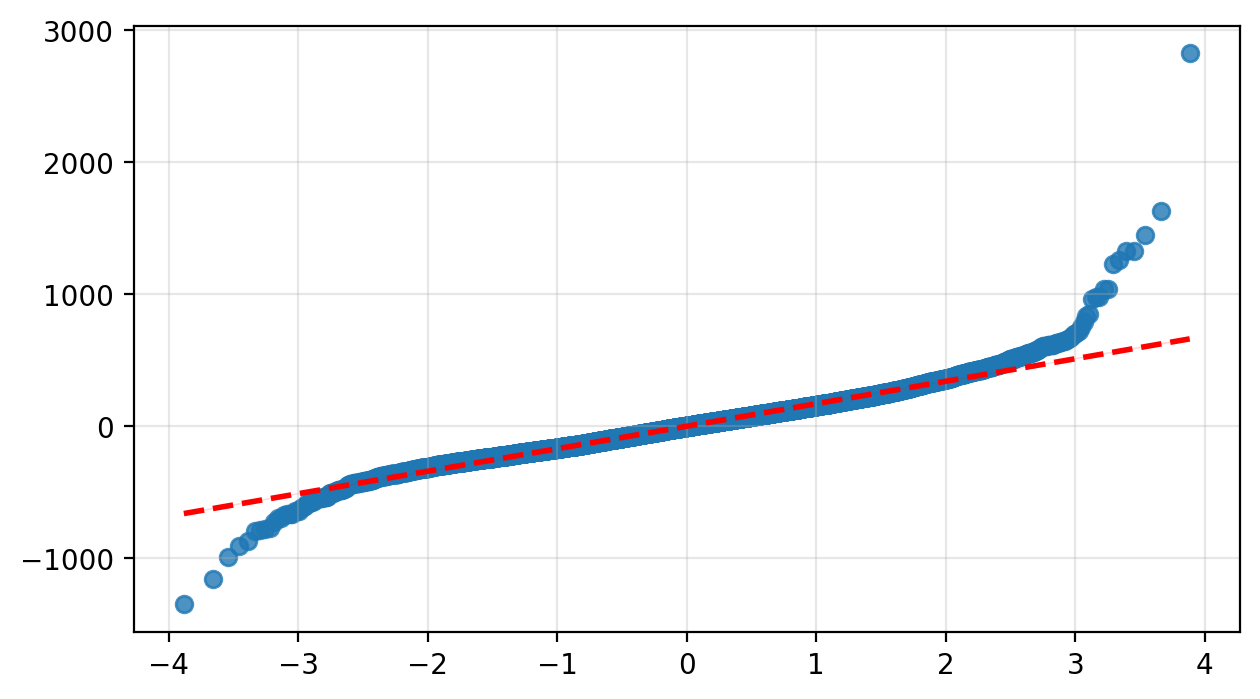

In [72]:
(x, y), _ = probplot(fit.resid)
# 1) 그래프 초기화
width_px = 1280  # 그래프 가로 크기
height_px = 720  # 그래프 세로 크기
rows = 1  # 그래프 행 수
cols = 1  # 그래프 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)
# 2) regplot 그리기
sb.regplot(
    x=x, y=y, line_kws={"color": "red", "linestyle": "--", "linewidth": 2}  # 점선
)
# 3) 그래프 꾸미기
ax.grid(True, alpha=0.3)  # 배경 격자 표시
# 4) 출력
plt.tight_layout()  # 여백 제거
plt.show()  # 그래프 화면 출력
plt.close()  # 그래프 작업 종료

In [74]:
r

'𝑅(0.847), 𝑅^2(0.846), 𝐹(4119.), 유의확률(0.00), Durbin-Watson(1.181)'

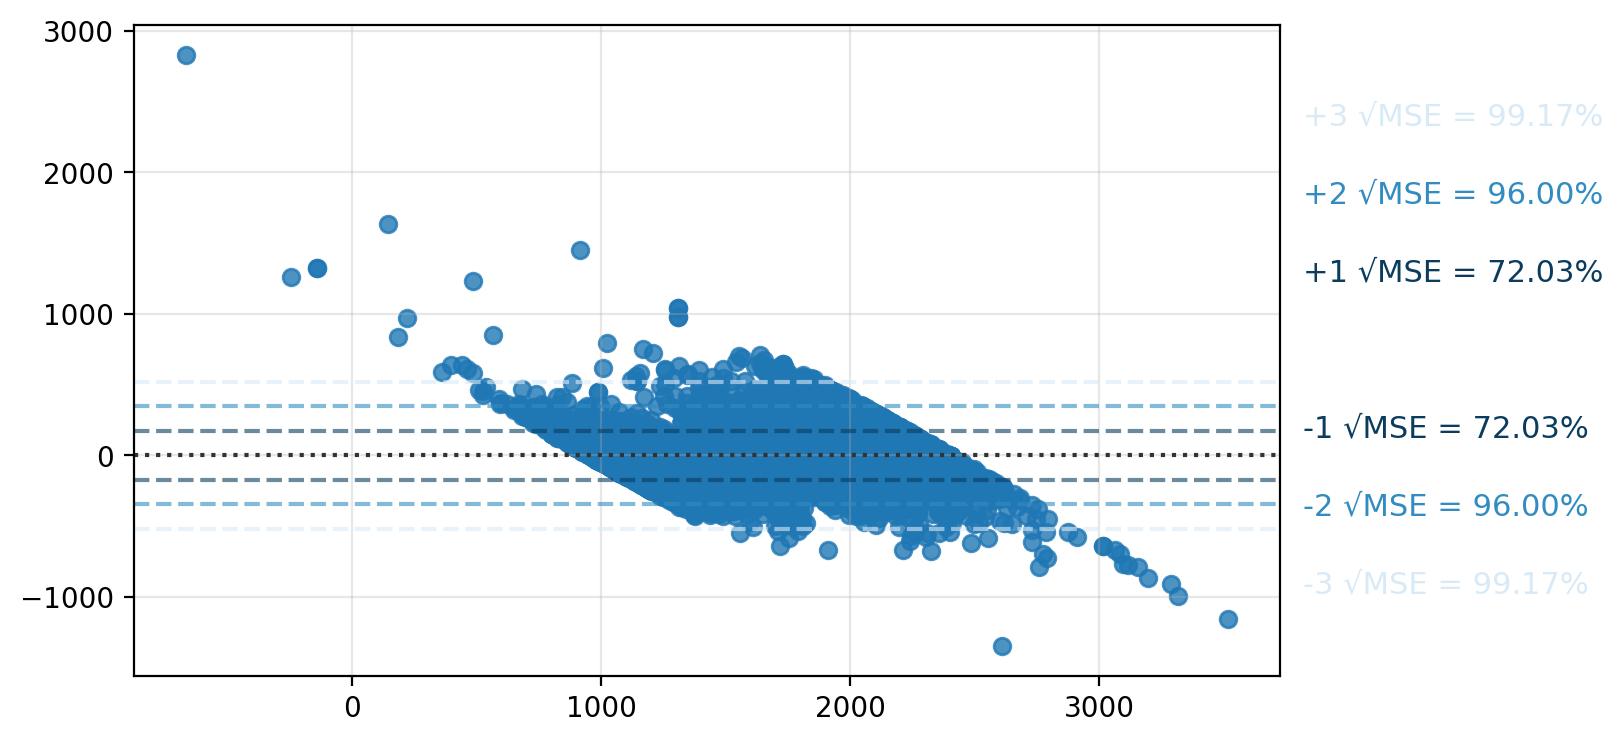

In [75]:
mse_sq = fit.mse_resid
mse_root = np.sqrt(mse_sq)
r = fit.resid  # 잔차

r1 = r[(r > -mse_root) & (r < mse_root)].count() / r.count() * 100
r2 = r[(r > -2 * mse_root) & (r < 2 * mse_root)].count() / r.count() * 100
r3 = r[(r > -3 * mse_root) & (r < 3 * mse_root)].count() / r.count() * 100

mse_r = [r1, r2, r3]

mse_r = [r1, r2, r3]
colors = ["#0B3C5D", "#328CC1", "#D9EAF7"]
xmax = fit.fittedvalues.max()
ymin = fit.fittedvalues.min()
# 1) 그래프 초기화
width_px = 1600
height_px = 720
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=my_dpi, constrained_layout=True)
# 2) seaborn 기본 잔차도
sb.residplot(x=fit.fittedvalues, y=fit.resid)
# 3) 꾸미기
ax.grid(True, alpha=0.3)
# 4) MSE 3단계 표시
for i, c in enumerate(colors):
    k = i + 1
    # 올바른 ±k√MSE 위치
    y_pos = k * mse_root
    ax.axhline(y=y_pos, color=c, linestyle="--", alpha=0.6)
    ax.axhline(y=-y_pos, color=c, linestyle="--", alpha=0.6)
    # 텍스트는 축 좌표계 사용 (그래프 밖으로 안 나감)
    ax.text(
        x=1.02,
        y=0.5 + 0.12 * k,
        s=f"+{k} √MSE = {mse_r[i]:0.2f}%",
        transform=ax.transAxes,
        ha="left",
        va="center",
        fontsize=11,
        color=c,
    )
    ax.text(
        x=1.02,
        y=0.5 - 0.12 * k,
        s=f"-{k} √MSE = {mse_r[i]:0.2f}%",
        transform=ax.transAxes,
        ha="left",
        va="center",
        fontsize=11,
        color=c,
    )
# 5) 출력
plt.show()
plt.close()

In [77]:
if len(df1q2) < 5000:
    method = "Shapiro-Wilk"
    stat, p = shapiro(fit.resid)
    print(f"{method} statistic: {stat:.4f}, p-value: {p:.4f}")
    violated = p < 0.05
else:
    method = "Anderson-Darling"
    ad_res = anderson(fit.resid, dist="norm")
    crit_levels = ad_res.significance_level.tolist()
    crit_values = ad_res.critical_values.tolist()
    crit_5 = crit_values[crit_levels.index(5.0)] if 5.0 in crit_levels else None
    print(f"{method} statistic: {ad_res.statistic:.4f}, 5% 임계값: {crit_5:.4f}")
    violated = crit_5 is not None and ad_res.statistic > crit_5
print(
    "정규성 가정 위배 가능성이 있음 (5% 유의수준)"
    if violated
    else "정규성 가정 위배 근거 없음 (5%유의수준)"
)

Anderson-Darling statistic: 23.5704, 5% 임계값: 0.7870
정규성 가정 위배 가능성이 있음 (5% 유의수준)


In [78]:
# Breusch–Pagan Test
names = ["LM Statistic", "LM p-value", "F Statistic", "F p-value"]
bp_test = het_breuschpagan(fit.resid, fit.model.exog)
bp = DataFrame(bp_test, index=names, columns=["value"])
# p-value는 F p-value를 기준으로 사용
p_bp = bp.loc["F p-value", "value"]
print(
    f"Breusch–Pagan statistic: {bp.loc['F Statistic','value']:.3f}, p-value ={p_bp:.3f}"
)
print(f"{'이분산성 존재(등분산 아님)' if p_bp <= 0.05 else '등분산성 만족'}")

Breusch–Pagan statistic: 35.228, p-value =0.000
이분산성 존재(등분산 아님)


In [79]:
m

'price에 대하여 carat,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,color_E,color_F,color_G,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(18,13443) = 4119., p ≤ 0.05).'

In [80]:
print("\n".join(v))

carat의 회귀계수는 4670.0579(p ≤ 0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
cut_Good의 회귀계수는 88.6587(p ≤ 0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
cut_Ideal의 회귀계수는 194.6242(p ≤ 0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
cut_Premium의 회귀계수는 168.1241(p ≤ 0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
cut_Very Good의 회귀계수는 141.6123(p ≤ 0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
color_E의 회귀계수는 -86.2959(p ≤ 0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
color_F의 회귀계수는 -141.5719(p ≤ 0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
color_G의 회귀계수는 -202.7447(p ≤ 0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
color_H의 회귀계수는 -315.3971(p ≤ 0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
color_I의 회귀계수는 -473.9949(p ≤ 0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
color_J의 회귀계수는 -670.1068(p ≤ 0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
clarity_IF의 회귀계수는 1638.7477(p ≤ 0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
clarity_SI1의 회귀계수는 1044.7059(p ≤ 0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
clarity_SI2의 회귀계수는 842.5338(p ≤ 0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
clarity_VS1의 회귀계수는 